<a href="https://colab.research.google.com/github/avilash/neural-networks-numpy/blob/master/Function_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a feed-forward neural network only in **numpy** to overfit to a standard mathematical function (in this case the **sine**) in a given range

## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Model Forward and Backward

In [0]:
def act(x):
  return np.maximum(x, 0.)

In [0]:
def act_back(incoming_gradient, activation):
  incoming_gradient[activation == 0.] = 0.
  return incoming_gradient

In [0]:
def create_model(layer_sizes, input_size, output_size):
  model = []
  current_input_size = input_size
  for i, layer_size in enumerate(layer_sizes):
    layer = {}
    layer["W"] = np.random.randn(current_input_size, layer_size) / np.sqrt(current_input_size)
    layer["b"] = np.zeros(layer_size, dtype=np.float32)
    model.append(layer)
    current_input_size = layer_size
    
  layer = {}
  layer["W"] = np.random.randn(current_input_size, output_size) / np.sqrt(current_input_size)
  layer["b"] = np.zeros(output_size, dtype=np.float32)
  model.append(layer)

  return model

In [0]:
def forward(input, model):
  model_len = len(model)
    
  activations = []
  current_act = input
  activations.append(current_act)
 
  
  for i in range(model_len-1):
    layer = model[i]
    # print ("prev_A = {}, W = {}, B = {}".format(current_act.shape, layer['W'].shape, layer['b'].shape))
    current_act = act(np.matmul(current_act, layer['W']) + layer['b'])
    # print ("A = {}".format(current_act.shape))
    activations.append(current_act)

  layer = model[model_len-1]
  # print ("prev_A = {}, W = {}, B = {}".format(current_act.shape, layer['W'].shape, layer['b'].shape))
  pred = np.matmul(current_act, layer['W']) + layer['b']
  # print ("A = {}".format(pred.shape))
  activations.append(pred)
  
  
  return activations, pred

In [0]:
def backward(gradient, activations, model):
  gradients = []
  Z_grad = gradient.copy()
    
  activation_len = len(activations)
  
  for i in range(activation_len-2, -1, -1):
    grad = {}
    prev_A = activations[i]
    W = model[i]['W']
    grad['W'] = prev_A.T.dot(Z_grad)
    grad['b'] = np.sum(Z_grad, axis=0)
    grad['A'] = Z_grad.dot(W.T)
    gradients.insert(0, grad)
    Z_grad = grad['A'].copy()
    Z_grad = act_back(Z_grad, prev_A)
    
  return gradients
  

In [0]:
def ms_loss(y_pred, y):
  loss = np.square(y_pred - y)
  return loss

In [0]:
def ms_loss_back(y_pred, y):
  loss_back = 2*(y_pred-y)
  return loss_back

## Data Generation

In [0]:
def generate_data():
  x = np.linspace(-1.0*np.pi, 1.0*np.pi, num=20000)
  e = np.random.normal(0, 0.005, x.size)
  y_f = np.sin(x)
  y = np.sin(x) + e
  return x, y_f, y

In [0]:
def plot_data(x, y_f, y):
  fig, ax = plt.subplots()
  if y_f is not None:
    ax.plot(x, y_f)
  ax.scatter(x, y, s=1)
  plt.show()

In [0]:
def split_train_test(x, y, test_percentage):
  x_size = x.shape[0]
  test_size = int(round(test_percentage/100.*x_size))
  indices = np.random.permutation(x.shape[0])
  test_idx, train_idx = indices[:test_size], indices[test_size:]
  x_test, x_train = x[test_idx], x[train_idx]
  y_test, y_train = y[test_idx], y[train_idx]
  
  return x_train, y_train, x_test, y_test

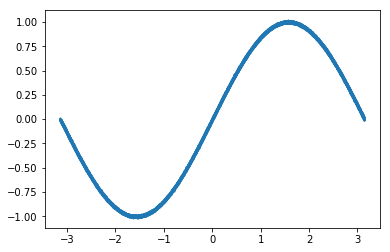

In [0]:
x, y_f, y = generate_data()
x_train, y_train, x_test, y_test = split_train_test(x, y, 0.)
plot_data(x_train, None, y_train)

## Training Procedure

### Weight Update

In [0]:
def update_weights(model, gradients, lr = 0.001):
  for i, grad in enumerate(gradients):
    model[i]['W'] -= lr*grad['W']
    model[i]['b'] -= lr*grad['b']
      
  return model

In [0]:
def init_rmsprop_params(model):
  rmsprop_params = []
  for layer in model:
    rmsprop_param = {}
    rmsprop_param['W'] = np.zeros_like(layer['W'])
    rmsprop_param['b'] = np.zeros_like(layer['b'])
    rmsprop_params.append(rmsprop_param)
  
  return rmsprop_params

In [0]:
def update_weights_rmsprop(model, gradients, rmsprop_params, lr = 0.001, beta=0.9):
  for i, grad in enumerate(gradients):
    v = beta*rmsprop_params[i]['W'] + (1.-beta)*np.square(grad['W'])
    model[i]['W'] -= (lr*grad['W'] / np.sqrt(v + 1e-14))
    rmsprop_params[i]['W'] = v
    
    v = beta*rmsprop_params[i]['b'] + (1.-beta)*np.square(grad['b'])
    model[i]['b'] -= (lr*grad['b'] / np.sqrt(v + 1e-14))
    rmsprop_params[i]['b'] = v
      
  return model, rmsprop_params

### Gradient check

In [0]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
def grad_check(model, gradients, x_batch, y_batch):
  layer = 0
  layer_x = 0
  layer_y = 0
  grad_num = gradients[layer]['W'][layer_x][layer_y]

  h = 0.00001
  oldval = model[layer]['W'][layer_x][layer_y]
  model[layer]['W'][layer_x][layer_y] = oldval - h
  _ , y_pred1 = forward(x_batch, model)
  loss1 = ms_loss(y_pred1, y_batch)
  model[layer]['W'][layer_x][layer_y] = oldval + h
  _ , y_pred2 = forward(x_batch, model)
  loss2 = ms_loss(y_pred2, y_batch)
  grad_ana = (loss2 - loss1) / (2.*h)
  grad_ana = np.sum(grad_ana)
  
  model[layer]['W'][layer_x][layer_y] = oldval

  error = rel_error(grad_num, grad_ana)
  return error

### Training/Test Loop

In [0]:
D_in, D_out = 1, 1
hidden_layers = [100]
model = create_model(hidden_layers, D_in, D_out)
rmsprop_params = init_rmsprop_params(model)
net_size = len(hidden_layers)

train_size = x_train.shape[0]
test_size = x_test.shape[0]

batch_start = 0
batch_end = 0

epochs = 500
batch_size = 1000
num_batches = int(round(train_size / batch_size))

should_grad_check = True
if should_grad_check:
  x_batch = np.expand_dims(x_train[0:batch_size], axis=1)
  y_batch = np.expand_dims(y_train[0:batch_size], axis=1)
  activations, y_pred = forward(x_batch, model)
  loss = ms_loss(y_pred, y_batch).mean()
  loss_grad = ms_loss_back(y_pred, y_batch)
  gradients = backward(loss_grad, activations, model)
  err = grad_check(model, gradients, x_batch, y_batch)
  print ("Gradient Check - Rel Error = {} \n".format(err))

loss_summary = 0
for epoch in range(epochs):
  loss = 0
  for i in range(num_batches):
    batch_start = (i%num_batches)*batch_size
    batch_end = min(train_size, batch_start+batch_size)
    x_batch = np.expand_dims(x_train[batch_start:batch_end], axis=1)
    y_batch = np.expand_dims(y_train[batch_start:batch_end], axis=1)

    activations, y_pred = forward(x_batch, model)

    loss += ms_loss(y_pred, y_batch).mean()

    loss_grad = ms_loss_back(y_pred, y_batch)

    gradients = backward(loss_grad, activations, model)
        
    model, rmsprop_params = update_weights_rmsprop(model, gradients, rmsprop_params, lr=0.0001)
  
  if (epoch+1)%20 == 0:
    print ("Epoch {} Loss = {}".format(epoch+1, loss/num_batches))
    loss_summary = 0
  else:
    loss_summary += loss

Gradient Check - Rel Error = 4.406373888546297e-12 

Epoch 20 Loss = 0.16657028565528886
Epoch 40 Loss = 0.12172470833960478
Epoch 60 Loss = 0.0813841244265466
Epoch 80 Loss = 0.0558919694905186
Epoch 100 Loss = 0.04158196896866
Epoch 120 Loss = 0.028978750969706302
Epoch 140 Loss = 0.01757701242794659
Epoch 160 Loss = 0.00882320230309065
Epoch 180 Loss = 0.0036351146952212235
Epoch 200 Loss = 0.0012984278416177768
Epoch 220 Loss = 0.000510946875716817
Epoch 240 Loss = 0.00024393252506375849
Epoch 260 Loss = 0.00015341435018136849
Epoch 280 Loss = 0.00010897929033152397
Epoch 300 Loss = 8.82935623451998e-05
Epoch 320 Loss = 7.496269085299053e-05
Epoch 340 Loss = 6.717626744786651e-05
Epoch 360 Loss = 6.206806740602548e-05
Epoch 380 Loss = 5.861803391409044e-05
Epoch 400 Loss = 5.615937002595734e-05
Epoch 420 Loss = 5.429361564631993e-05
Epoch 440 Loss = 5.2886008616538616e-05
Epoch 460 Loss = 5.1731525178403746e-05
Epoch 480 Loss = 5.0958913873490035e-05
Epoch 500 Loss = 5.013253656245

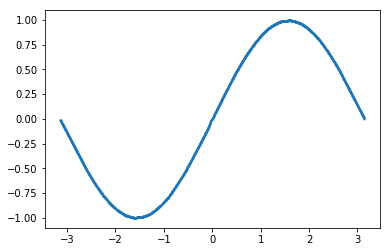

In [0]:
x_fun = np.expand_dims(np.linspace(-1.0*np.pi, 1.0*np.pi, num=2000), axis=1)
activations, y_pred = forward(x_fun, model)
plot_data(x_fun.squeeze(), None, y_pred.squeeze())